In [2]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
started


In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [4]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def gen_rasch_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [ ]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

In [9]:
# n_students, n_questions, n_factors, min_active, max_active = 100,150,100,1,5

# numpy.set_printoptions(precision=3)
# test_w = 5
# #rasch a0 = 3
# # a0 = 0.26 #bayes10
# a0 = (0.2,1)
# a1 = None
# # obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)
# obs, probs, students, questions  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

# plt.hist(students.flatten(), alpha=0.5)
# plt.hist(questions.flatten(), alpha=0.5)
# plt.show()

# plt.hist(probs.flatten())
# plt.show()

# plt.hist(obs.flatten())
# plt.show()

In [5]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, Flatten
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

#     psi_row = Flatten(Embedding(psi_n, 100, input_length=1)(psi_sel))
#     qn_row = Flatten(Embedding(qn_n, 100, input_length=1)(qn_sel))
    
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    print("Mode is", _mode)
    if _mode=="DEEP":
        difs = subtract([psi_row, qn_row])
        h = Dense(50, activation="relu")(difs)
        h = Dense(50, activation="relu")(h)
        h = Dense(50, activation="relu")(h)
        h = Dense(20, activation="relu")(h)
        score = Dense(1, activation="sigmoid")(h)        
    elif _mode=="COND":
        Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
#     elif _mode=="BINQ":
#         Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
#         score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    elif _mode=="MLTM":
        klip = Lambda(lambda qk: K.clip(qk,-10, -9)+10)
        q_masque = klip(qn_row)
        difs = subtract([psi_row, qn_row])
        Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
        Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    else:
        if _mode!="MXFN":
            print("Invalid mode:", _mode, "- valid modes are COND, MLTM, MXFN (using default: MXFN)")
        _mode=="MXFN"
        scores = Lambda(lambda qp: qp[0] * qp[1])([qn_row, psi_row])
        score = Lambda(lambda s: K.sum(s, keepdims=True, axis=1), name="sum")(scores)
#         score = Lambda(lambda qp: K.batch_dot(qp[0], qp[1], axes=1), name="dot_prod")([qn_row, psi_row])
    #     score = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(score)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)

#     if _mode=="BINQ":
#         from_half = Lambda(lambda x: 1+K.sum((0.25-(x-0.5)**2)) )
#         s_loss = from_half(psi_table.kernel)
#         q_loss = from_half(qn_table.kernel)
#         def custom_loss(s_loss,q_loss):
#             def orig_loss(yt,yh):
#                 return K.binary_crossentropy(yt,yh) * s_loss * q_loss
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#             return orig_loss
#         model.compile(optimizer=optimiser, loss=custom_loss(s_loss, q_loss), metrics=["accuracy"])
#         return model
    
    print("loss mode is", loss)
    if loss=="MSE":
        model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
    else:
        if loss!="XENT":
            print("loss mode must be MSE or XENT, not", loss," - setting to XENT.")
            loss="XENT"            
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])     
    print(model.summary())

    return model

In [6]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [57]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        for p in probs.flatten():
            inps.append([tw,a1, p])
            outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    inps = numpy.array(inps)
    outs = numpy.array(outs)
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
#     for nnw in [2,4,8,16,32]:
#         for nnd in [0,1,2,3,5]:
    for nnw in [20]:
        for nnd in [3]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            mse = gen_m.evaluate(inps, outs)
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = gen_m.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(gen_m.evaluate(inps, outs))
    return gen_m

In [8]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [9]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_loss"
        val_dat= [[vqz,vsz], vpfz]
    else:
        lozz="loss"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)
        tr_predz = (m.predict([qz,sz]) > 0.5)
        v_predz  = (m.predict([vqz,vsz]) > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
        print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        
        _bs = len(pfz)
#         _bs = 32
        h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=_bs, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])  
        v_predz  = m.predict([vqz,vsz])

        print("TR AVG = ", numpy.mean(tr_predz))
        print("TR R2  = ", r2_score(pfz, tr_predz))
        print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
        print("TR ACC = ", accuracy_score(pfz, (tr_predz>0.5)))
        print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
        if val_dat:
            print("VA AVG = ", numpy.mean(v_predz))
            print("VA R2  = ", r2_score(vpfz, v_predz))
            print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
            print("VA ACC = ", accuracy_score(vpfz, (v_predz>0.5)))
            print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

    from sklearn.metrics import classification_report
    print(classification_report(pfz, (tr_predz>0.5)))
    print(classification_report(vpfz, (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [11]:
def stitch_n_split(_pairs, _probs):
    _pfz = numpy.array([int((random.random() < _probs[vi,mi])) for (vi,mi) in _pairs])
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in pairs])
    _sz = [p[0] for p in _pairs]
    _qz = [p[1] for p in _pairs]
    return _pfz, _sz, _qz

c [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 0.01 0.01
c [0 0 1 0 0 0 0 2 2 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 2
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 0 1 1 1 0 0 0 3 0 1 0 0 0 0 2 0 0 2 0 0 1 1 0 1 0]
17 0.33 0.44
c [0 1 2 1 0 2 1 3 2 2 2 0 1 2 0 0 0 1 0 2 0 0 0 0 4 1 0 1 0 0 1 0 3 0 0 1 4
 0 0 0 2 1 0 0 2 1 0 0 2 0 0 0 1 1 1 0 2 1 0 1 2 0 0 1 0 0 1 1 1 0 1 0 0 1
 0 0 2 1 1 1 2 1 4 0 3 0 0 1 0 2 1 0 3 1 0 3 1 0 1 0]
34 0.54 0.88
c [2 2 3 2 1 2 2 3 2 2 2 1 1 2 2 0 0 1 0 3 0 0 0 1 4 3 0 2 0 1 2 0 3 1 0 1 4
 1 0 0 2 1 0 0 3 2 0 1 2 0 0 1 3 3 1 1 2 2 0 1 3 0 1 1 1 0 2 2 2 0 3 0 0 1
 0 0 2 2 1 1 2 2 4 0 4 0 0 1 0 3 1 0 3 1 0 4 1 0 1 1]
50 0.68 1.31
c [2 2 5 2 2 2 4 4 2 4 2 3 2 2 2 1 1 2 1 3 2 0 0 2 4 3 0 2 0 1 2 0 3 3 3 2 4
 1 0 1 2 1 0 1 3 2 0 2 2 1 2 2 4 4 1 1 2 4 0 1 3

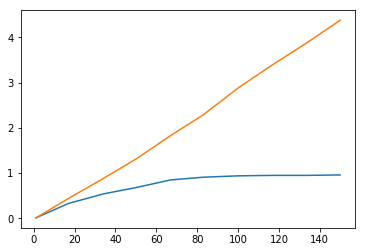

In [50]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [20]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [15]:
gen_m_cache = {}

In [67]:
tup = (100,1,5)
n_factors, min_active, max_active = tup

if tup in gen_m_cache:
    del gen_m_cache[tup]
print("creating genny")
gen_m = create_offset_generator(n_factors, min_active, max_active, sampsize=10, n_iter=20000)
gen_m_cache[tup] = gen_m


creating genny
generating generator training mini-datasets...
1 0.837509233885448
2 0.19823760703962004
3 0.2270567657915812
4 0.8745697638028714
5 0.6946308773557448
6 0.7734544807556153
7 0.581085991115448
8 0.22187314848123313
9 0.7627967288118348
10 0.5777972337226746
11 0.6929589556360696
12 0.8508542282971666
13 0.6690002837956018
14 0.3091917611313858
15 0.19456482214093287
16 0.11883767058677105
17 0.6322772238685525
18 0.40994443375993794
19 0.1913031422643262
20 0.19765822264998614
21 0.6980257549744713
22 0.6498492641749285
23 0.46237785151560484
24 0.13718523322079973
25 0.33930248183164846
26 0.2569037639849569
27 0.5757010113653106
28 0.7675020144097058
29 0.11689983013053099
30 0.3087202795217574
31 0.8775467598514587
32 0.15667250711953956
33 0.16077651545944355
34 0.3765550252280005
35 0.5745702810205597
36 0.1825074231116041
37 0.14254167097376824
38 0.48702939253478966
39 0.4301184844336233
40 0.23525958409336659
41 0.11386028191745044
42 0.5884154073543774
43 0.3867

457 0.14463599779327407
458 0.7566214289883207
459 0.4075794251334443
460 0.17169750467283965
461 0.13890689353996177
462 0.14704687286585513
463 0.34578402312394463
464 0.6016157595665692
465 0.39601259467931715
466 0.8622623920871593
467 0.8725834642575667
468 0.8221364765345686
469 0.11113955098789276
470 0.7541652434793854
471 0.34918470072047836
472 0.32059217261293105
473 0.8215898547734716
474 0.8041570407413524
475 0.6265542006051056
476 0.11755788446058121
477 0.21549939184159309
478 0.2882845467257964
479 0.455637785233078
480 0.4606137384966614
481 0.336032316486427
482 0.3231363153243477
483 0.7818877533945486
484 0.27000256702559355
485 0.30605522153729664
486 0.206559998627134
487 0.1592794086634465
488 0.6706014858777114
489 0.426613730544835
490 0.32364732824756876
491 0.45046689710148313
492 0.3395460874145214
493 0.8869403300880968
494 0.4037450596373688
495 0.626872257147225
496 0.20104656545579874
497 0.8505867563343562
498 0.256426857038241
499 0.46925442965202097


824 0.1766073224098769
825 0.5124914962275301
826 0.48098570052747613
827 0.6383443921162035
828 0.7159163322194398
829 0.20783226278336836
830 0.11033986366043574
831 0.36784170155258644
832 0.8359841226335549
833 0.8988404109112913
834 0.10966683790991173
835 0.14778575396981025
836 0.25832461743192264
837 0.19715168083619708
838 0.27882073455141415
839 0.3040530457372376
840 0.5789634717285784
841 0.884165348419782
842 0.5620628328208631
843 0.1767341637810165
844 0.4322500164346708
845 0.7947928866175845
846 0.39343799907293975
847 0.45338380676198603
848 0.4616101395527384
849 0.5282074179141861
850 0.14292109181655843
851 0.8464335990358655
852 0.8517205135231528
853 0.8880344130815456
854 0.8789505917703393
855 0.5353721971346326
856 0.5427269373815259
857 0.44913510529339135
858 0.22313554175599815
859 0.4450741118956593
860 0.27555357513332046
861 0.4272989966578964
862 0.16441999870277432
863 0.2705676424621661
864 0.887268572326339
865 0.8221284856884266
866 0.21575092670784

1209 0.319293522788902
1210 0.638595649584368
1211 0.5587343610331948
1212 0.5938953012970645
1213 0.45221197504666777
1214 0.6182745886757688
1215 0.24257703033216657
1216 0.21175084636909342
1217 0.8056987671655133
1218 0.5509510111712048
1219 0.19994964487662317
1220 0.49914051997759123
1221 0.6292499089190721
1222 0.4161152607802157
1223 0.8877311364928459
1224 0.8667262327234292
1225 0.129850198425846
1226 0.5672600081754049
1227 0.5871389571320311
1228 0.6640721008093089
1229 0.234742256983428
1230 0.19173860273726906
1231 0.6991588306887911
1232 0.13589316901462864
1233 0.14103426647842135
1234 0.7629584867514104
1235 0.8266360344524329
1236 0.5093942799594176
1237 0.26386640684144697
1238 0.4966749089491971
1239 0.21812348421648645
1240 0.5689322997280963
1241 0.11765121916612255
1242 0.17379126660944338
1243 0.36914999901757345
1244 0.4401200022597769
1245 0.32117362757067264
1246 0.3755415735508244
1247 0.5048742989865296
1248 0.11923203527172285
1249 0.21788989242784787
1250

1587 0.8011569493800127
1588 0.6904285348437658
1589 0.20503746877623416
1590 0.11661507279379067
1591 0.4545606293897443
1592 0.7472892056193711
1593 0.753382617278274
1594 0.4024479086697568
1595 0.2700196179999798
1596 0.31404648887958775
1597 0.7910485650939403
1598 0.7761168876306827
1599 0.36776573883977526
1600 0.4704082984585369
1601 0.516914427703946
1602 0.4751192547474135
1603 0.3383595600855906
1604 0.7283431736187066
1605 0.7556013550755032
1606 0.24655341220054608
1607 0.8241794849743784
1608 0.6273728545442725
1609 0.6979726412595924
1610 0.17790045399189286
1611 0.5480596109700803
1612 0.7294561563946838
1613 0.17312621610764561
1614 0.42014243218725933
1615 0.23990977039800634
1616 0.7442026913575265
1617 0.7722451605579012
1618 0.35276656228821024
1619 0.1639092509697768
1620 0.13911388828134932
1621 0.7527290509447779
1622 0.31137021187353026
1623 0.5978219516007999
1624 0.19558772774909158
1625 0.25327621497732594
1626 0.790509043594786
1627 0.3831123513580302
1628 

1964 0.37258023542569235
1965 0.647151604507675
1966 0.5955807003346312
1967 0.3238603388697901
1968 0.5684888874740597
1969 0.13757252369406647
1970 0.3227744188102463
1971 0.34858977696146803
1972 0.6612182895087698
1973 0.2083139957444663
1974 0.16546986602667807
1975 0.8722882059202282
1976 0.18131342902664205
1977 0.8272813750864967
1978 0.2816229713591461
1979 0.5866222132651792
1980 0.1389502610516254
1981 0.12992398966699376
1982 0.5112968105996155
1983 0.3576054774353924
1984 0.7798983213782626
1985 0.8577147677745727
1986 0.3471362354118492
1987 0.762646848163641
1988 0.2837515009899504
1989 0.22024334183951821
1990 0.7137288337847122
1991 0.743031513874467
1992 0.6916188403169654
1993 0.7081112341782735
1994 0.4855287378455302
1995 0.5900335206698717
1996 0.11234021817178144
1997 0.18195729881501407
1998 0.1238069829563961
1999 0.3191887781385074
2000 0.47969050334599794
2001 0.884643612997882
2002 0.6498656300960389
2003 0.1027427468809794
2004 0.17818616376728058
2005 0.84

2341 0.4565689516315311
2342 0.6951955111779458
2343 0.7987014274465885
2344 0.7181743865395586
2345 0.11547372195244511
2346 0.7533389869115278
2347 0.7522644122739993
2348 0.44649601332340144
2349 0.32969357636944296
2350 0.24591138872691773
2351 0.6274411044633463
2352 0.41504531612801504
2353 0.8070944545319865
2354 0.34283656816705255
2355 0.469602641993022
2356 0.3581602513492082
2357 0.42596787026161026
2358 0.6066317517153155
2359 0.7057502243968563
2360 0.28082522780877295
2361 0.7700786165323263
2362 0.2648097134183067
2363 0.47733308480917896
2364 0.8527906926508076
2365 0.40913212036173713
2366 0.8229420633326979
2367 0.13099000567549313
2368 0.8585820122236132
2369 0.39082515458541706
2370 0.3052646938209323
2371 0.7581304812293209
2372 0.7089262766412158
2373 0.242393781695826
2374 0.4009613264507632
2375 0.7475902604323933
2376 0.19056862185467843
2377 0.351381624780148
2378 0.79786588697242
2379 0.2960380608831238
2380 0.23596825338884705
2381 0.583712934915763
2382 0.5

2720 0.24328698540617902
2721 0.8249024544853074
2722 0.13642423229954
2723 0.24621867509418321
2724 0.7840960778509192
2725 0.611378040618088
2726 0.11763354444876777
2727 0.24132579155137987
2728 0.5804772200998687
2729 0.1765312278433201
2730 0.10312430246188518
2731 0.6675103673346058
2732 0.17106218708072976
2733 0.781341563246844
2734 0.20152353901174774
2735 0.6009496422506571
2736 0.7687281287988386
2737 0.19747203108560363
2738 0.34489356116615466
2739 0.7171539756076593
2740 0.1452532202152273
2741 0.7585543406532099
2742 0.4959653383677069
2743 0.5793005155391908
2744 0.3604999129546695
2745 0.49551274959682856
2746 0.46714204074445875
2747 0.12956922171605773
2748 0.15867214368246446
2749 0.17238436177751634
2750 0.5865913057581309
2751 0.6047184558508967
2752 0.1340945006696899
2753 0.1595355027810729
2754 0.26021975580594864
2755 0.1399271338658911
2756 0.13110639554612527
2757 0.789543763472155
2758 0.6429518093850825
2759 0.6122357094205021
2760 0.17868107570062125
2761

3095 0.12722657268680343
3096 0.8514591405576483
3097 0.17595918953909814
3098 0.6954109250196149
3099 0.36060306571410305
3100 0.1132969703939904
3101 0.21326669073305396
3102 0.5502759313163635
3103 0.13989832873952088
3104 0.8870671563552393
3105 0.5415537059175376
3106 0.6441490431398361
3107 0.40165488462135146
3108 0.20000354656713473
3109 0.28805994928431844
3110 0.11434200572441944
3111 0.21645563049326944
3112 0.18263244138615595
3113 0.8773147218199402
3114 0.5214617314796118
3115 0.6207544744192132
3116 0.2434145309414126
3117 0.32295680660754306
3118 0.6353195849713
3119 0.8280342425013585
3120 0.3346690860404333
3121 0.8900805333905614
3122 0.3774843107152506
3123 0.5658082785221173
3124 0.6980736600946447
3125 0.8853377221680861
3126 0.8876940977055218
3127 0.25040363284471867
3128 0.21406791378311657
3129 0.8019269008501714
3130 0.43402166358125865
3131 0.19114851333538121
3132 0.3440701010082078
3133 0.24275172959083505
3134 0.3896917972706044
3135 0.315867546564332
313

3472 0.1954083239612811
3473 0.6387465103422325
3474 0.6477251148642186
3475 0.7317081373203107
3476 0.11655796166392256
3477 0.7256497127729951
3478 0.3039973577335257
3479 0.2759479661036779
3480 0.1414393514343135
3481 0.6279655226339473
3482 0.7096748978694271
3483 0.8602586522170177
3484 0.7777129501049704
3485 0.5480695527211146
3486 0.7322150358730664
3487 0.45553680731422763
3488 0.6671693240494284
3489 0.38449282095884507
3490 0.3434770048311768
3491 0.574611328360014
3492 0.6234619871848369
3493 0.4358807931550216
3494 0.8532481803321516
3495 0.6140172500268218
3496 0.44655899846797015
3497 0.18413021663331156
3498 0.1616924131806989
3499 0.21033010617095513
3500 0.6015933960960614
3501 0.8036707254930833
3502 0.10304470628269435
3503 0.3082906544674847
3504 0.42968326282123415
3505 0.5390710036236245
3506 0.8258404343141087
3507 0.7362389382061165
3508 0.10196055404609251
3509 0.15967677643539693
3510 0.15451229698390273
3511 0.2084971786115934
3512 0.8590438410154554
3513 0

3839 0.20835026892368935
3840 0.12329783049000359
3841 0.7027260679236398
3842 0.2302622751039854
3843 0.10884939559009289
3844 0.23376897011124512
3845 0.8816742186894085
3846 0.46047100950750663
3847 0.3063724260944378
3848 0.14149029226572232
3849 0.5822399334496116
3850 0.1395991971637378
3851 0.7673222703330921
3852 0.8087876110137221
3853 0.7773298332346424
3854 0.6389302880075738
3855 0.810342690054695
3856 0.5111618377585689
3857 0.2273491847631395
3858 0.10166258626673524
3859 0.89984301457571
3860 0.8576477133512056
3861 0.12994829362072066
3862 0.3696358057163459
3863 0.17665267217077843
3864 0.1001215072400744
3865 0.2541431008980139
3866 0.5893877864068381
3867 0.5257195246937798
3868 0.853015531354277
3869 0.8791674195418138
3870 0.13461780772289175
3871 0.5896496005087656
3872 0.7850267157165706
3873 0.49244604285564847
3874 0.797019495595462
3875 0.4130343661060107
3876 0.291224524552005
3877 0.8059853537932037
3878 0.6015904035197078
3879 0.6257393785485267
3880 0.1428

4197 0.6693744509245034
4198 0.13732788485744957
4199 0.3355873132059666
4200 0.6071822981314402
4201 0.7849362082727529
4202 0.7972078472061883
4203 0.3934164686257461
4204 0.5271147140176194
4205 0.5554173227465709
4206 0.722686018473126
4207 0.3709785787277023
4208 0.16208081984406614
4209 0.3313811467967783
4210 0.6846597506839385
4211 0.803722351766407
4212 0.6536849285157565
4213 0.6572716912231874
4214 0.1543398178138432
4215 0.11684124728863463
4216 0.20476473774171433
4217 0.3704391167572382
4218 0.7103690401689005
4219 0.8848141264376428
4220 0.38331255266215175
4221 0.7013367186643361
4222 0.6634063488525281
4223 0.5651527598589319
4224 0.2362108651284463
4225 0.1345368543350949
4226 0.8617916486911295
4227 0.26182183790136365
4228 0.8254077955337695
4229 0.840921039258384
4230 0.5420753493167998
4231 0.1298895793298265
4232 0.2004592383409191
4233 0.16420255593863964
4234 0.15331228540523426
4235 0.693087797153903
4236 0.8971139340464306
4237 0.30773147912992926
4238 0.8335

4586 0.5952124430403342
4587 0.1590833288154063
4588 0.5519149769707088
4589 0.28071823357264447
4590 0.8875391192023679
4591 0.5127096113236449
4592 0.14661582420794314
4593 0.14043273969278564
4594 0.13867300977157807
4595 0.3631664614678779
4596 0.6785976073985621
4597 0.6432336087604523
4598 0.7597774809104781
4599 0.14116250855266435
4600 0.5562274365422339
4601 0.15263106544615304
4602 0.535345884724724
4603 0.8741125818717639
4604 0.6956190741613122
4605 0.5436733845995774
4606 0.5123361751593948
4607 0.7358841000690577
4608 0.1412592506055525
4609 0.7051423635052345
4610 0.13481263938175186
4611 0.66601418729798
4612 0.147824023960257
4613 0.49208113892781985
4614 0.16700157102852248
4615 0.32339324392353125
4616 0.7968576345472015
4617 0.7015825600107064
4618 0.5152401916066688
4619 0.3926315773786591
4620 0.4865898238831635
4621 0.8078447763907751
4622 0.8387119009665996
4623 0.8211056988087022
4624 0.27329017892886726
4625 0.44353102423093244
4626 0.8125982237533754
4627 0.2

4936 0.7092004074895331
4937 0.16256445539972586
4938 0.7161115148275072
4939 0.8427615605612903
4940 0.8688062009388378
4941 0.8389117171267539
4942 0.14808901810675013
4943 0.8208996723790771
4944 0.4654947668342183
4945 0.8818361552314586
4946 0.8437721102109524
4947 0.12333052127960284
4948 0.42005587989780085
4949 0.3301953716323446
4950 0.7561073560119019
4951 0.6575879614037051
4952 0.17616919565571318
4953 0.8646132974822042
4954 0.18224949970292453
4955 0.4244937073354491
4956 0.12530970114401976
4957 0.5982188799676155
4958 0.36430378966240373
4959 0.6980594282638629
4960 0.630855781662731
4961 0.5712030033537217
4962 0.8245082322949301
4963 0.7821265163806365
4964 0.25061468945562315
4965 0.7108481391236644
4966 0.2253787208894069
4967 0.8904201522828158
4968 0.7589186955720417
4969 0.14726679669768025
4970 0.1193463220312437
4971 0.8023591223977842
4972 0.7012692040318067
4973 0.5334315069578732
4974 0.48297563125223525
4975 0.59940592219707
4976 0.6765901295951607
4977 0.2

5310 0.7713487432841102
5311 0.4081085010359436
5312 0.8019691101814264
5313 0.5169850196713531
5314 0.640621815020093
5315 0.611217223993369
5316 0.8321098948351999
5317 0.6312386370005203
5318 0.8942967107933271
5319 0.4295314121047944
5320 0.19674676235184413
5321 0.19734718523877987
5322 0.3035804328036647
5323 0.695931902373287
5324 0.2616096624402199
5325 0.2253291409949359
5326 0.13921516695382624
5327 0.2490351039704405
5328 0.8175189882554357
5329 0.4881848080555863
5330 0.4159460966900659
5331 0.1439726149450218
5332 0.1989127782582445
5333 0.12987927857840542
5334 0.5579748757987208
5335 0.8906091490405769
5336 0.8241030399220682
5337 0.7536034764589199
5338 0.2217495378185172
5339 0.24843824709898277
5340 0.5292868823619722
5341 0.11969544083882738
5342 0.8655770507132938
5343 0.6186014667173713
5344 0.766534655953823
5345 0.4857700783578389
5346 0.10752023562609482
5347 0.26820406390566837
5348 0.7457514330947371
5349 0.11069943188143978
5350 0.512733998369179
5351 0.28571

5663 0.7179595642248928
5664 0.8479625552700498
5665 0.6727126525336758
5666 0.28088281763484185
5667 0.7797976608086535
5668 0.14713538440240048
5669 0.44825863814923883
5670 0.1106558473723037
5671 0.6592780253351704
5672 0.25507385474236105
5673 0.8894996906106768
5674 0.5298154043183343
5675 0.36013025637536833
5676 0.7906231436826685
5677 0.11576291887341172
5678 0.6062329734256121
5679 0.21354155682342743
5680 0.5851053519694789
5681 0.6866322408962561
5682 0.3812107826472145
5683 0.6321439948442102
5684 0.1586864488706723
5685 0.4450703675600352
5686 0.10258365160169089
5687 0.594099626014136
5688 0.24346007350821983
5689 0.1150394446827891
5690 0.8519214646974147
5691 0.3633636933722145
5692 0.20060394289990818
5693 0.8984196361117435
5694 0.6903368991127316
5695 0.5387842782718827
5696 0.1911055968326452
5697 0.6848217975906018
5698 0.7490685609099524
5699 0.20528468489813725
5700 0.6439314246085602
5701 0.764612314093771
5702 0.7872734407227121
5703 0.8240234786314439
5704 0.

6057 0.29777932003370744
6058 0.8901957718529735
6059 0.16174630866548867
6060 0.8260076331192655
6061 0.8073176742770926
6062 0.7949848667229972
6063 0.8815104940670806
6064 0.6105653922180164
6065 0.24261528002345165
6066 0.866286554974762
6067 0.1223169341725523
6068 0.2327103323414873
6069 0.4574558431406744
6070 0.7290554338981694
6071 0.5846643498544551
6072 0.45314182271392095
6073 0.8767493055878183
6074 0.19592218022340743
6075 0.6283789154588845
6076 0.7968753050753555
6077 0.7241791617195902
6078 0.4662268416281974
6079 0.7125874563729769
6080 0.5955037638713689
6081 0.3870638926023023
6082 0.8721484916313749
6083 0.23921140351884077
6084 0.17873827523843647
6085 0.40200886452210516
6086 0.7002216787331674
6087 0.32974866402732467
6088 0.10972133891318889
6089 0.14699093688997342
6090 0.7483495995150793
6091 0.7861582732009599
6092 0.6940531326152343
6093 0.14684302666553126
6094 0.8748619769983936
6095 0.2604044962229931
6096 0.4603134190912659
6097 0.8959613769102065
6098 

6412 0.5719743241601412
6413 0.7169535367539889
6414 0.19406525376382824
6415 0.8970723518780482
6416 0.2580965432263879
6417 0.14537311769991756
6418 0.6458628170253123
6419 0.8897908038282687
6420 0.773204998054466
6421 0.2571517228796374
6422 0.296781901860189
6423 0.7543960705252954
6424 0.1372422125594093
6425 0.6565289906963923
6426 0.5002911966821363
6427 0.3257378625383132
6428 0.8860435963107549
6429 0.703532424742776
6430 0.49883107287280887
6431 0.6229234431063381
6432 0.7744890695345262
6433 0.4652824809888845
6434 0.6508372558014871
6435 0.5419092839286366
6436 0.3603938656829268
6437 0.6627187675108361
6438 0.38045731687380047
6439 0.39868165153923396
6440 0.3479313306559807
6441 0.4002258501337534
6442 0.7874561117192226
6443 0.16394365178348794
6444 0.10529705043337613
6445 0.26205322219580957
6446 0.38822546075750575
6447 0.4095382160516968
6448 0.6351218154941867
6449 0.8925612463640004
6450 0.6222481783160911
6451 0.3389001549937271
6452 0.756556216357828
6453 0.2755

6789 0.14671994602638538
6790 0.3525191661681087
6791 0.4838648666942901
6792 0.6623099158585516
6793 0.8381639070716905
6794 0.46413542303220456
6795 0.3963703897891792
6796 0.15563831327030245
6797 0.7454059992288868
6798 0.333886732977418
6799 0.17113965506376422
6800 0.8389512378171512
6801 0.2114089955378933
6802 0.6831439682143764
6803 0.3019490781890296
6804 0.641425721120094
6805 0.35161309892507775
6806 0.17970052014889176
6807 0.8597801666850908
6808 0.31992809370018277
6809 0.3529564728537946
6810 0.15858277411531516
6811 0.5076495076696325
6812 0.8310213860134958
6813 0.2778479334466528
6814 0.28870052403000107
6815 0.19291583016969943
6816 0.13873519055853115
6817 0.46133989724968794
6818 0.108664098485004
6819 0.3963055218795712
6820 0.39421492457874624
6821 0.7693562335525889
6822 0.45817104017336613
6823 0.5489802709981009
6824 0.28812255605447634
6825 0.11347623010526518
6826 0.7289393030236245
6827 0.8755512816928779
6828 0.4181294946108026
6829 0.34955288495903847
68

7153 0.4931859302507329
7154 0.8961931309936274
7155 0.5068708815660474
7156 0.4751867908902306
7157 0.671826456232765
7158 0.703435305534341
7159 0.1984818866327389
7160 0.11662314899669156
7161 0.7835063983968813
7162 0.33056826561612873
7163 0.5249136647501971
7164 0.888016215017463
7165 0.8404735424474616
7166 0.4939918928579068
7167 0.2342790808912901
7168 0.11272917118950498
7169 0.5639167690983816
7170 0.21136597579831448
7171 0.1537787935240764
7172 0.7161784286987649
7173 0.17928695703166653
7174 0.5935634849568856
7175 0.11468880487600157
7176 0.4138151617159169
7177 0.30636053351229076
7178 0.651043449330731
7179 0.6968250947098397
7180 0.8020642783524192
7181 0.8012059657038434
7182 0.7210934351783154
7183 0.42220049566008194
7184 0.7303635134848891
7185 0.22598415731201343
7186 0.756287520000084
7187 0.4267182489107516
7188 0.5229200077121832
7189 0.26371671084155396
7190 0.8435793357415933
7191 0.2557626393093089
7192 0.538238079303838
7193 0.4938029443907821
7194 0.23408

7529 0.17585265628473223
7530 0.23522244151627014
7531 0.786605628074597
7532 0.7866363132881593
7533 0.29823750702765117
7534 0.8334941041048146
7535 0.6355287917686195
7536 0.6606938215064657
7537 0.8683263062018403
7538 0.6104830759434206
7539 0.12764864291261696
7540 0.32902834449147805
7541 0.8019034985483972
7542 0.7281294777779538
7543 0.8063648583058429
7544 0.5570495010414998
7545 0.13523531921910525
7546 0.4798040390923843
7547 0.4692194375907707
7548 0.24359003062885579
7549 0.43475954987589843
7550 0.6923219138264288
7551 0.7347617276828461
7552 0.7857777176447565
7553 0.4451562099487459
7554 0.5665072574524462
7555 0.17999574206660462
7556 0.6837399535671952
7557 0.820855202906175
7558 0.49440430852679906
7559 0.2877180748260597
7560 0.853142176955343
7561 0.579688512492974
7562 0.10774429517564477
7563 0.6723780815233288
7564 0.11294911991051693
7565 0.46003048991900714
7566 0.2637395885229619
7567 0.1106067168660003
7568 0.6408509266140868
7569 0.7478679389820367
7570 0.

7893 0.6279324909040187
7894 0.34785227828768717
7895 0.20112870706272015
7896 0.14214472405508968
7897 0.7050529167860047
7898 0.4147305236738518
7899 0.7305379478669612
7900 0.8246819678673792
7901 0.3714686424807052
7902 0.7864860628445549
7903 0.4987464149224402
7904 0.8123959328593466
7905 0.8353503525692089
7906 0.4447262816247568
7907 0.23375747097881613
7908 0.24905213836269607
7909 0.10285048083689509
7910 0.816802563694495
7911 0.8973161471399949
7912 0.5580490735734351
7913 0.7402674880583815
7914 0.3908069286656446
7915 0.11268099913786357
7916 0.12695803242682907
7917 0.12368754673660642
7918 0.44624838168046305
7919 0.2264605320652109
7920 0.33511810096316735
7921 0.6780346580756921
7922 0.42109855016983144
7923 0.6755355688209188
7924 0.4683485101270473
7925 0.6485802492747065
7926 0.6010266418182383
7927 0.18738383210960702
7928 0.8826877368303326
7929 0.8202818087241271
7930 0.12189263140473806
7931 0.7334846180293882
7932 0.7234337183506192
7933 0.14787497351425716
79

8273 0.8224335288986587
8274 0.7271418669472168
8275 0.5107268701940958
8276 0.10887980390293255
8277 0.7337448745167394
8278 0.7874369574692452
8279 0.6184891313922599
8280 0.10145770496634865
8281 0.6593295450083863
8282 0.44139945134337377
8283 0.4052584813628695
8284 0.7677621283145146
8285 0.14583884750312587
8286 0.8603917909870079
8287 0.20752311948539331
8288 0.7673412012579699
8289 0.10159418065074621
8290 0.15534310099661908
8291 0.8227102249798339
8292 0.2825672818324892
8293 0.701058024310521
8294 0.1917495056836147
8295 0.5707848101638944
8296 0.42551229709554983
8297 0.665760569985919
8298 0.18658219589652483
8299 0.17616942098079683
8300 0.8507891278148758
8301 0.5776360491092246
8302 0.18482991006703883
8303 0.2636009184353421
8304 0.47126301701365914
8305 0.48739257171898154
8306 0.2143535932112886
8307 0.757609776759947
8308 0.398455477950857
8309 0.10617790104450167
8310 0.7451389757315889
8311 0.8003228417599827
8312 0.12208987964490595
8313 0.18539640337195937
8314

8632 0.618323495836643
8633 0.19920406416910333
8634 0.12311029899180584
8635 0.34455357290535926
8636 0.2923576214401589
8637 0.10799539633965288
8638 0.5015103079957245
8639 0.657429845244289
8640 0.5918075602374907
8641 0.8948579685444229
8642 0.4128144009252102
8643 0.29795995777421835
8644 0.5739902385998672
8645 0.8488049901749243
8646 0.4752134862819078
8647 0.573459234951739
8648 0.22829370844350455
8649 0.8828870932673258
8650 0.42556410285589735
8651 0.847633927333269
8652 0.652530108814888
8653 0.3919178412091253
8654 0.43904965274508395
8655 0.33353488801407943
8656 0.20568324023721823
8657 0.3092168308663774
8658 0.43684903824724186
8659 0.22479455310332971
8660 0.1442745176135899
8661 0.18198113752991713
8662 0.4844683826097376
8663 0.5191876340411817
8664 0.11879004361851084
8665 0.4942479128624751
8666 0.8154283199132485
8667 0.657108964061874
8668 0.6308979992518909
8669 0.8753802746901163
8670 0.29356297099104817
8671 0.4889100761116497
8672 0.7289384000087764
8673 0.

8994 0.768556091859543
8995 0.21822124310549243
8996 0.2709110082220805
8997 0.31413097748319463
8998 0.29451920810049836
8999 0.13647448190039502
9000 0.6630064035382405
9001 0.24530499312802062
9002 0.3535894200378889
9003 0.17904098514990754
9004 0.8421140447986452
9005 0.7208797267976621
9006 0.806163665904934
9007 0.6431459912960998
9008 0.2562856676688993
9009 0.48503835838047654
9010 0.6549236165177885
9011 0.8046871274957823
9012 0.8907312652678214
9013 0.2986678726951311
9014 0.3815849542864795
9015 0.24124224732994426
9016 0.25249513200570484
9017 0.41490092578530374
9018 0.8768040784525469
9019 0.5720198894546157
9020 0.8110960216176862
9021 0.5125561840680586
9022 0.4373964877095644
9023 0.5123810349176637
9024 0.17497726182870252
9025 0.21870028419350918
9026 0.8276567767066708
9027 0.1327049720321129
9028 0.897111371855191
9029 0.15589037298855465
9030 0.30523511963209743
9031 0.48434884753513885
9032 0.8369216105687513
9033 0.8032121398977641
9034 0.10171384428071538
903

9378 0.6091876018632012
9379 0.8363459466971116
9380 0.11425748763623343
9381 0.752317201260489
9382 0.15779254278679372
9383 0.5864655578688498
9384 0.2734370460457207
9385 0.2539373777591712
9386 0.4034872619741562
9387 0.5823775709564704
9388 0.2823283859562199
9389 0.782555564029786
9390 0.11618542055762682
9391 0.58592352374224
9392 0.6039465237955352
9393 0.14436974583607934
9394 0.21012983387619705
9395 0.4541006287201525
9396 0.10951734588565877
9397 0.2496310746328856
9398 0.8051693297757427
9399 0.2069588143589508
9400 0.2711273746777079
9401 0.13859297068390913
9402 0.8880716287497163
9403 0.20989973483170032
9404 0.1426170060889648
9405 0.5629864524925171
9406 0.351596153201388
9407 0.1343020435702855
9408 0.4273118231665628
9409 0.39549313433220445
9410 0.40680724615713965
9411 0.10116126421119073
9412 0.3333322510736601
9413 0.7432432685268917
9414 0.2579211249660844
9415 0.7990729022613999
9416 0.6579037270219321
9417 0.8696842564092636
9418 0.7286409320026361
9419 0.370

9751 0.40661826706305815
9752 0.24014730773647291
9753 0.4988933554515527
9754 0.13339397706503597
9755 0.45762933551156204
9756 0.30647171796684153
9757 0.16852580850443488
9758 0.4249053953896247
9759 0.1666875601143389
9760 0.7006350305892173
9761 0.37293776218897107
9762 0.12003633654280803
9763 0.6567719219127404
9764 0.8611825643010865
9765 0.8109474260783687
9766 0.1965929358535803
9767 0.10501590861699417
9768 0.10952217996574959
9769 0.8757768550156596
9770 0.551355236460179
9771 0.6856845782201342
9772 0.8305646915166272
9773 0.7721058839291491
9774 0.23948761576055322
9775 0.48724344915174717
9776 0.7430115059164903
9777 0.8081259391263483
9778 0.6811929456005287
9779 0.6802865010284788
9780 0.4360986433904592
9781 0.8442125008958838
9782 0.5485222013546677
9783 0.1082599087606567
9784 0.3862197940557935
9785 0.43449773043227924
9786 0.4936981540526714
9787 0.5152425146978765
9788 0.14425811060603594
9789 0.764096358652874
9790 0.6851142074351675
9791 0.19919916346277575
979

10112 0.1489802555841649
10113 0.14259643105156727
10114 0.10031363060008601
10115 0.27726238212088977
10116 0.4637965338777486
10117 0.7105808254774092
10118 0.41969387004442127
10119 0.30761223707748925
10120 0.24034282796356685
10121 0.6706037788851749
10122 0.8657201695955644
10123 0.1364840192625115
10124 0.8897846734180476
10125 0.5519553198729678
10126 0.31793804957430677
10127 0.6033283742493941
10128 0.24636279728988375
10129 0.28444008788698755
10130 0.12807633398419807
10131 0.6837017977311938
10132 0.5829692162873178
10133 0.23669344392707703
10134 0.3965832731796103
10135 0.8426499114943603
10136 0.7881827497042054
10137 0.7841917435918198
10138 0.2309357717537051
10139 0.8752317942264178
10140 0.10896399342419559
10141 0.14591160242891235
10142 0.828949648497833
10143 0.37820833047502117
10144 0.5633232907874212
10145 0.8364655056563439
10146 0.8780558424238659
10147 0.587518347134785
10148 0.1632083066418376
10149 0.4853708698398639
10150 0.8992113699343671
10151 0.76015

10479 0.30514334159598216
10480 0.16415866928029388
10481 0.26732075950210754
10482 0.4200499857165614
10483 0.7768904932795818
10484 0.14648396015404583
10485 0.1365115727730511
10486 0.33943952167829045
10487 0.36036234640202874
10488 0.3332107109915682
10489 0.6336803409589036
10490 0.17836888138063053
10491 0.8322016406246149
10492 0.35012043433662443
10493 0.48711461074265805
10494 0.47957780069333916
10495 0.6757192228331323
10496 0.1087663712066496
10497 0.8700868880021322
10498 0.7628684732837141
10499 0.21877407469517496
10500 0.27592192124808834
10501 0.6205691274786155
10502 0.8761722053827307
10503 0.380592756443423
10504 0.20984620621134142
10505 0.5289994111987755
10506 0.8358514995092916
10507 0.5605133469574224
10508 0.7337789060280456
10509 0.8720128445702756
10510 0.4026222145600283
10511 0.8861567927560089
10512 0.8754829884970892
10513 0.28516241754077704
10514 0.36086042959016884
10515 0.7202458526558568
10516 0.27072611017017184
10517 0.6063711849686871
10518 0.41

10846 0.2381599006880905
10847 0.6641401807262156
10848 0.6263796707556439
10849 0.44986349793963154
10850 0.26903172539367093
10851 0.6239375336785008
10852 0.5938325176267916
10853 0.3438883397203108
10854 0.3577293322676806
10855 0.7566755918237402
10856 0.6902750917964056
10857 0.2692970951409268
10858 0.35192633682661023
10859 0.6121806779604769
10860 0.7443607034243543
10861 0.7216200947911752
10862 0.6853786235173943
10863 0.8964312464497912
10864 0.6566589331608709
10865 0.7995962852698092
10866 0.8687196344652107
10867 0.5433657090665015
10868 0.1595875886234588
10869 0.1339193279675575
10870 0.5205581163865906
10871 0.48366147921153785
10872 0.38966417210003346
10873 0.22979394276183523
10874 0.5768625290685284
10875 0.19857746211177565
10876 0.869747253812722
10877 0.5827220078732644
10878 0.13774433290291108
10879 0.6965583756884943
10880 0.4683158998042366
10881 0.4981374928153843
10882 0.8083202478998326
10883 0.8311209259443509
10884 0.1798427301410812
10885 0.2777945918

11208 0.2943649912679806
11209 0.58219669774869
11210 0.11177990168386825
11211 0.4691911605607664
11212 0.7364900165889909
11213 0.34711357624958944
11214 0.855564383656797
11215 0.5474450414886417
11216 0.8227870992876725
11217 0.8443756163358486
11218 0.595904244952302
11219 0.39048041423449215
11220 0.8245753431872008
11221 0.1440192898778371
11222 0.21898764332430468
11223 0.33565149670716526
11224 0.5077997746093673
11225 0.2180304879632123
11226 0.7621183819115875
11227 0.7295804903672706
11228 0.7571636160363922
11229 0.720010868753479
11230 0.8297884218728683
11231 0.6394569555733827
11232 0.3801464799743751
11233 0.10709537088747417
11234 0.7014906183766028
11235 0.4113252590044235
11236 0.20694844099688062
11237 0.15953906788580416
11238 0.4677385471417367
11239 0.210534125006516
11240 0.538753145439345
11241 0.740912492126033
11242 0.14126696041373932
11243 0.24489744682259293
11244 0.2958699517506481
11245 0.8765191182419693
11246 0.30900444065961646
11247 0.41433798752636

11570 0.2215519536090026
11571 0.31803298135600433
11572 0.5915818142944003
11573 0.8382109675195317
11574 0.1796074461877117
11575 0.5415349456181031
11576 0.11458605096260316
11577 0.27658518994808856
11578 0.6729785866789556
11579 0.8184256871978016
11580 0.17830066870830785
11581 0.16632540514659913
11582 0.504007394692501
11583 0.16613469733872324
11584 0.11513128603817131
11585 0.5983867242955901
11586 0.4230852331579826
11587 0.14662019561943812
11588 0.2819725948219425
11589 0.8329436445267422
11590 0.5540753427283647
11591 0.5071125586742767
11592 0.5100337193205071
11593 0.6386469400921466
11594 0.2963163864260435
11595 0.18137967839819896
11596 0.28089581915727246
11597 0.788586674726758
11598 0.17100013112317317
11599 0.6459634648002577
11600 0.4225911649461957
11601 0.8205869477945681
11602 0.5627418917041284
11603 0.27563724377778986
11604 0.3608397049417027
11605 0.8854418249785743
11606 0.5585821888692614
11607 0.6908660610427387
11608 0.15546818877193577
11609 0.236381

11919 0.1440941517658409
11920 0.43905724437987326
11921 0.3427858741759945
11922 0.4085803001728034
11923 0.6209525887918922
11924 0.7311602480499836
11925 0.43716357615591084
11926 0.22793199202846995
11927 0.11927595783757901
11928 0.10112838710355514
11929 0.5185864609033938
11930 0.137946453514885
11931 0.19450378624930037
11932 0.8303240773839936
11933 0.7846644849854746
11934 0.844379093018907
11935 0.844864716073179
11936 0.2185441361087277
11937 0.25538688654102143
11938 0.4831392058200376
11939 0.17588568520010905
11940 0.6556769168483674
11941 0.36491340409187495
11942 0.17482812923684343
11943 0.8966583030850152
11944 0.14889838476262576
11945 0.18570741810888772
11946 0.20315892823718065
11947 0.7470971611332375
11948 0.6590093272874107
11949 0.8340905560818166
11950 0.5428026884268785
11951 0.11993782355489421
11952 0.19895043495312548
11953 0.4721275289460087
11954 0.35028913551472907
11955 0.8742059629331634
11956 0.4940348250191806
11957 0.46736693233435994
11958 0.114

12278 0.2658241999534766
12279 0.740758159781202
12280 0.6392294975259943
12281 0.6578861278541507
12282 0.10820498017006959
12283 0.28691661605838964
12284 0.39369412498165773
12285 0.23722223818370874
12286 0.5384957590717937
12287 0.3586995161815286
12288 0.7697205708410195
12289 0.38664318815864884
12290 0.4315019152317149
12291 0.13856260048261848
12292 0.870837250316839
12293 0.6723730991478077
12294 0.11160275861272365
12295 0.42105199294419426
12296 0.5338302169205777
12297 0.36199862978097463
12298 0.1438947237348707
12299 0.10861573800211824
12300 0.23883604886434748
12301 0.5960979484954184
12302 0.44086836660234474
12303 0.3935867299741332
12304 0.18853057168150264
12305 0.6773782085314847
12306 0.14813307376649576
12307 0.23617268410394793
12308 0.12213595094554787
12309 0.4722256629378168
12310 0.7575545341738491
12311 0.29962452014415303
12312 0.3344790823019979
12313 0.6274026522088976
12314 0.3433869567732803
12315 0.2729968445415363
12316 0.15801923636481782
12317 0.1

12643 0.12268497618740067
12644 0.1671762909769691
12645 0.7277152011570428
12646 0.7987150362301219
12647 0.21327060600793774
12648 0.27748490539774007
12649 0.25373536605164254
12650 0.5216765411729362
12651 0.20711232708353627
12652 0.7862333111934544
12653 0.12010914233726706
12654 0.7161155222927388
12655 0.20826457448929514
12656 0.2531437360703642
12657 0.47779065920337976
12658 0.4198550831836613
12659 0.12467917331917051
12660 0.809041887468908
12661 0.7854893983309668
12662 0.502681672490221
12663 0.2750832136260471
12664 0.17966560422944025
12665 0.16107169340031582
12666 0.5032862952563765
12667 0.41948206642462166
12668 0.17462672059844309
12669 0.6349628155634414
12670 0.20841357599397423
12671 0.408700479559076
12672 0.15280611148617562
12673 0.7749226398821567
12674 0.843275681026856
12675 0.30342349387902323
12676 0.24494743661683563
12677 0.1482049177461089
12678 0.47384892119047645
12679 0.6373719530593689
12680 0.49034704268403306
12681 0.5748923204977973
12682 0.43

13017 0.413413548499747
13018 0.16350126465331657
13019 0.5539854583617854
13020 0.13912732929990132
13021 0.5394174197284147
13022 0.47569407506792927
13023 0.7627960297634708
13024 0.892795908216339
13025 0.8204767118843713
13026 0.4330165818249944
13027 0.12649149834794726
13028 0.10257528155585255
13029 0.8148649167638486
13030 0.723904257597719
13031 0.8852315360657599
13032 0.8305403034379765
13033 0.4420867178612265
13034 0.20109122342330857
13035 0.668006315206292
13036 0.7130227209719968
13037 0.7110358933588193
13038 0.17199464818687257
13039 0.47252640749448654
13040 0.44996279652525356
13041 0.1818847984346722
13042 0.863251224868967
13043 0.6452704706255534
13044 0.3446957211808298
13045 0.14472922494960433
13046 0.787325542319555
13047 0.4790168119227406
13048 0.7429361760227366
13049 0.5464038979156107
13050 0.4519962305101035
13051 0.2035697654116355
13052 0.6918680713007574
13053 0.19039102203513322
13054 0.7024420010514033
13055 0.11850681501149946
13056 0.42587991976

13383 0.26846382890014103
13384 0.259213386414735
13385 0.44244071674933605
13386 0.23767441543371146
13387 0.27143974243658486
13388 0.38139657492348195
13389 0.8400264318843352
13390 0.2294899917750429
13391 0.28202369190971416
13392 0.3261270286866611
13393 0.5809819584549044
13394 0.5825048609102009
13395 0.12122242788745087
13396 0.6877270055301125
13397 0.8046443677874574
13398 0.8373599004359922
13399 0.10088387202072993
13400 0.13415700052197838
13401 0.35004353019917217
13402 0.3827593031578733
13403 0.11627993507506158
13404 0.17316047590625472
13405 0.3143778073849536
13406 0.8589833311376982
13407 0.12315685425858298
13408 0.36883367597958466
13409 0.4880621594457709
13410 0.8437929561830431
13411 0.35685359599554284
13412 0.13721969126646608
13413 0.8108553380593075
13414 0.24458617598220703
13415 0.6446295582226713
13416 0.13248768318603152
13417 0.23275964158478457
13418 0.17770511949668447
13419 0.7162611152330302
13420 0.819874422059626
13421 0.31137159877692394
13422 

13751 0.17022091179716214
13752 0.3302189085810059
13753 0.37934788518063756
13754 0.6018015652421324
13755 0.7655035835669323
13756 0.2645192419473259
13757 0.6464836990734306
13758 0.1897442383737488
13759 0.799923092693892
13760 0.29759783946309365
13761 0.21058598189452146
13762 0.16548313577996318
13763 0.393348574624189
13764 0.43057876947727003
13765 0.49164927854215923
13766 0.11273257019394751
13767 0.20429987697951188
13768 0.30061507157497164
13769 0.12040745571158085
13770 0.1801844079746465
13771 0.8450403454071481
13772 0.4735206810201109
13773 0.660520231413697
13774 0.6495846616053333
13775 0.35113969426774333
13776 0.1658105136065318
13777 0.42556964222531524
13778 0.791410991972017
13779 0.3191924796900244
13780 0.24851079272098225
13781 0.48340278129435976
13782 0.15134261172446078
13783 0.8710122409445706
13784 0.8842837664596147
13785 0.7912579036577195
13786 0.7400863996370446
13787 0.723246464865204
13788 0.8932469146506167
13789 0.868805961927892
13790 0.1324884

14111 0.24794229869704534
14112 0.810616044124694
14113 0.10006132760252516
14114 0.7080651222787079
14115 0.41396358403401307
14116 0.8078483485917102
14117 0.38134887668095635
14118 0.5893532224959237
14119 0.20855609511036044
14120 0.5354998603073086
14121 0.839840846276023
14122 0.653614841113822
14123 0.8664050966062351
14124 0.4125121594152861
14125 0.5637518507190308
14126 0.18133128141608817
14127 0.8051717070534048
14128 0.7402791724000318
14129 0.4718210652976893
14130 0.15754590187103443
14131 0.4755629846412302
14132 0.1470799661512374
14133 0.5966664807202813
14134 0.26699359538188444
14135 0.4106805454833439
14136 0.1791043912702695
14137 0.34149533065098875
14138 0.1469529469231885
14139 0.3436002983609097
14140 0.46850338632508504
14141 0.8017776804914655
14142 0.3402683742549492
14143 0.23084666805132065
14144 0.4342517547848823
14145 0.738865160152997
14146 0.6186797088187663
14147 0.1388053242787124
14148 0.3579970852143862
14149 0.5634215342228027
14150 0.8861076247

14459 0.8535143771961412
14460 0.8980658023047811
14461 0.7201514516834505
14462 0.38309290384326805
14463 0.5854010234788317
14464 0.5189703811375622
14465 0.525026431771678
14466 0.12351475701672375
14467 0.8169157539973457
14468 0.19372473036180837
14469 0.7253872193778091
14470 0.5956124827427292
14471 0.12754799957833302
14472 0.8252438103540886
14473 0.39503172190848673
14474 0.17842749884100256
14475 0.11823760822640456
14476 0.3848144502429515
14477 0.1327651757968812
14478 0.3138302942294794
14479 0.5709839617344381
14480 0.5263893069407373
14481 0.7790804076959241
14482 0.13707677012278993
14483 0.8536433559753429
14484 0.1372430430114386
14485 0.868274827978131
14486 0.42486664346637487
14487 0.6445623016807889
14488 0.8177795897894243
14489 0.2728020001193051
14490 0.6847505294299506
14491 0.38244085847455384
14492 0.45500119363338226
14493 0.42416617728307104
14494 0.3470357773843678
14495 0.6972852062892871
14496 0.1750618059601076
14497 0.2737191826865242
14498 0.5362264

14826 0.14570882859231413
14827 0.6497182807124017
14828 0.8531641685882616
14829 0.4974837486099194
14830 0.27087923103246314
14831 0.8721782723257726
14832 0.7129609088605579
14833 0.5282308388863628
14834 0.14743997060043698
14835 0.8800846958313312
14836 0.5706538838803158
14837 0.2560107063388366
14838 0.6016208297706223
14839 0.22008958071774276
14840 0.8706115984463535
14841 0.30642719916078637
14842 0.20929375518111404
14843 0.7433805196200726
14844 0.8621001138027774
14845 0.14231586540259125
14846 0.12024212082289082
14847 0.3204632415930683
14848 0.1983409458003568
14849 0.18435505063474084
14850 0.3913233761006478
14851 0.39694751068612966
14852 0.33340729378157447
14853 0.4644306336043536
14854 0.7552062499306073
14855 0.7538722647843601
14856 0.5737824020169885
14857 0.395017226308229
14858 0.8327331198270863
14859 0.24466647938395406
14860 0.7797702778214016
14861 0.3076707103007429
14862 0.49796773303908903
14863 0.21102860068322962
14864 0.34454423308373633
14865 0.370

15202 0.203274566156047
15203 0.8083236474365372
15204 0.33200908292109327
15205 0.3549107721154218
15206 0.814151146073886
15207 0.7438109964731296
15208 0.7564246566533361
15209 0.5135586858094705
15210 0.1155342328698291
15211 0.8553617338111287
15212 0.293377585543117
15213 0.20442899740322
15214 0.8692591646029383
15215 0.778723051408504
15216 0.7564411773686798
15217 0.476088194647268
15218 0.4275613174846133
15219 0.6785214819243722
15220 0.498010935260386
15221 0.8813473560092908
15222 0.7494294348969983
15223 0.1690200789967683
15224 0.8191584700130815
15225 0.270554742767767
15226 0.43851407496557127
15227 0.6921317402695296
15228 0.7428989783550378
15229 0.4028159505043488
15230 0.34805709227795306
15231 0.803969093116172
15232 0.8705574153133344
15233 0.2872460336404072
15234 0.8497273101583794
15235 0.19542889284955697
15236 0.3985606239907056
15237 0.8984636436325809
15238 0.30616175975380505
15239 0.2971469793141198
15240 0.5833266752575162
15241 0.8643401632832474
15242

15581 0.41827511711131254
15582 0.16779021470149008
15583 0.2879271540119711
15584 0.8759056569787487
15585 0.1801844062499533
15586 0.7223769020449212
15587 0.7048691954170488
15588 0.806329303613384
15589 0.10580451130341871
15590 0.4872784367744014
15591 0.38258680032875003
15592 0.15274908453985314
15593 0.16946253633983338
15594 0.6005108592744052
15595 0.7077277652875668
15596 0.5121683614320799
15597 0.6774441248506189
15598 0.6350216228309014
15599 0.7457735451277113
15600 0.40404028261791813
15601 0.7384914151440908
15602 0.1263412126330866
15603 0.674389359627295
15604 0.7142084235130316
15605 0.8468737990034914
15606 0.20075005542255336
15607 0.24662265532284847
15608 0.3758820636136029
15609 0.23366986664402906
15610 0.3954544419573021
15611 0.6070681876466729
15612 0.4416868627686814
15613 0.18198992975118314
15614 0.21815854466559448
15615 0.7748506598958018
15616 0.8581758770498259
15617 0.14446403343366354
15618 0.1263687339745837
15619 0.8044240734401679
15620 0.446141

15967 0.19162132549666977
15968 0.28614625297620355
15969 0.8210183200485014
15970 0.8840195474751432
15971 0.7398125495401535
15972 0.8100560129177155
15973 0.721114088507125
15974 0.2947478378775353
15975 0.3704429412786059
15976 0.18989032915774404
15977 0.7482180872077793
15978 0.24514036425059887
15979 0.5765526644828592
15980 0.464858636725705
15981 0.2529303485061228
15982 0.22096822585884288
15983 0.8221969779244838
15984 0.7063944393824937
15985 0.8478827132153746
15986 0.42415682752712724
15987 0.78282308150453
15988 0.6762868274556905
15989 0.16864954367089618
15990 0.419788150262602
15991 0.4281523346962288
15992 0.7574381686962329
15993 0.851666273919476
15994 0.7003261512023126
15995 0.2268980022126884
15996 0.209522120813566
15997 0.42938543711131827
15998 0.13251470810751015
15999 0.8414147126301716
16000 0.8824109023895617
16001 0.7162596903147362
16002 0.3451299298795986
16003 0.11603016643587809
16004 0.30682861070661965
16005 0.1694603615427915
16006 0.5107699986776

16344 0.20330627686458463
16345 0.7183122258045147
16346 0.4858917213934471
16347 0.8001453798646586
16348 0.6967707952288265
16349 0.342241703726478
16350 0.6883578318668842
16351 0.15051010721346977
16352 0.7061561186495545
16353 0.8885238864190086
16354 0.8506953274928151
16355 0.17568933634210596
16356 0.6615030400919077
16357 0.4447920499174586
16358 0.3151373316345365
16359 0.15458555222011258
16360 0.7644248311957901
16361 0.2727013623425574
16362 0.6882073258230785
16363 0.8661964244683477
16364 0.1555706804678941
16365 0.16114535619706272
16366 0.19309951286900956
16367 0.6540727565374225
16368 0.8556768127596706
16369 0.17905845204391857
16370 0.6371586349869456
16371 0.5084620947774838
16372 0.1562449131958514
16373 0.30196338796035527
16374 0.7865317300176667
16375 0.21192034137622226
16376 0.5282116050578782
16377 0.25445774682224315
16378 0.6314258807664315
16379 0.14428286797282788
16380 0.806389003009081
16381 0.28484406966176656
16382 0.5770649690412741
16383 0.3731044

16711 0.20753915819658889
16712 0.4438671626489446
16713 0.2997678805429379
16714 0.7772673220765872
16715 0.26679559978296996
16716 0.6060313831815797
16717 0.662428809168139
16718 0.7815023847639267
16719 0.13437755631201243
16720 0.8044150300452202
16721 0.6710970308823195
16722 0.7079181245845441
16723 0.5889243643707334
16724 0.2571503775875774
16725 0.46899903976074947
16726 0.10208337615130714
16727 0.34653254003546907
16728 0.2917704405947319
16729 0.280216291459658
16730 0.13171494984232418
16731 0.6888599664306236
16732 0.6818569449739346
16733 0.894898402433563
16734 0.7341657159938607
16735 0.3974801709768896
16736 0.7326088731562778
16737 0.11695288345027442
16738 0.18542079426835154
16739 0.41240132305830024
16740 0.6634850242363252
16741 0.6681615968034
16742 0.2101151749348342
16743 0.353239116107338
16744 0.7962169992693986
16745 0.5380151941501298
16746 0.16971635668532362
16747 0.8326913872377066
16748 0.1379979825495443
16749 0.47103024707483737
16750 0.209184140940

17085 0.10135159106239104
17086 0.7552016672628978
17087 0.67810200595584
17088 0.33142962429471673
17089 0.7490450330050894
17090 0.8963133822029349
17091 0.36383046095818294
17092 0.18703372442598687
17093 0.1543290377633327
17094 0.17747579920233716
17095 0.17235895962392628
17096 0.2044931710013545
17097 0.30460280695119557
17098 0.2016035811147084
17099 0.8974357361127
17100 0.2861270376265982
17101 0.4879722526379208
17102 0.7521138555690278
17103 0.559206242042707
17104 0.31750525191328777
17105 0.6300005077653144
17106 0.86749899552879
17107 0.11637568830853319
17108 0.1270829502978345
17109 0.46649732609714467
17110 0.48775556113080915
17111 0.43536722024020247
17112 0.2804433060978391
17113 0.6358999749133213
17114 0.7333871037477919
17115 0.8151272488244453
17116 0.332497668607013
17117 0.16338184164289546
17118 0.4118534376377943
17119 0.3305027666904053
17120 0.24321435486608764
17121 0.8772066027204607
17122 0.3256480516168305
17123 0.17572621952177636
17124 0.45554490375

17464 0.3409236831465494
17465 0.10243334065252017
17466 0.14645442748067694
17467 0.10962489706199861
17468 0.7487458083565286
17469 0.7865685188304837
17470 0.1484583625265577
17471 0.28502108776720053
17472 0.43555470260003376
17473 0.707188846916374
17474 0.5791793274493103
17475 0.6146336641421511
17476 0.805528389706184
17477 0.18649678188399016
17478 0.2562005307732698
17479 0.5783815937427209
17480 0.8329765722548961
17481 0.7772026873004333
17482 0.11641036065332111
17483 0.1689939395066572
17484 0.8668549762409856
17485 0.2976971215936376
17486 0.2588927114951683
17487 0.44005295089751495
17488 0.12522545808227567
17489 0.408205632022282
17490 0.2218752521244819
17491 0.1314952885548262
17492 0.11605037775864796
17493 0.2909058215288886
17494 0.74430269011902
17495 0.3087851409238876
17496 0.8289945020960845
17497 0.8277473871129878
17498 0.29306790275405753
17499 0.18910767806912546
17500 0.5639116867969522
17501 0.142704110444481
17502 0.1469886796195308
17503 0.21747795422

17834 0.15442958211401456
17835 0.5020546110068667
17836 0.6473587698329554
17837 0.5148873625599794
17838 0.43316503361791786
17839 0.7462158804695173
17840 0.8328280592514882
17841 0.4275356917500838
17842 0.23818445912752245
17843 0.6748364409740314
17844 0.33805105618391323
17845 0.6628905430102967
17846 0.4825054623969566
17847 0.5384650968975306
17848 0.7230662117254163
17849 0.24878586801037764
17850 0.7432822302486503
17851 0.10233809788767116
17852 0.34614680665291464
17853 0.22532799618878835
17854 0.8958893478007074
17855 0.8529260606739061
17856 0.3485622193083129
17857 0.6005786557405207
17858 0.7668112763941346
17859 0.5131816916658899
17860 0.8163703207663637
17861 0.14369489287862797
17862 0.5689740282446547
17863 0.4241801766496974
17864 0.603652632915144
17865 0.33873958499373724
17866 0.10684571936389531
17867 0.8738230904991938
17868 0.5544221817373133
17869 0.30646489221614165
17870 0.7248666898766637
17871 0.18205413726020175
17872 0.8612817941174048
17873 0.40955

18205 0.8765949060700032
18206 0.6938654121784485
18207 0.40197568343199486
18208 0.24907388559163945
18209 0.19057846328074532
18210 0.10741345789050841
18211 0.3900834268672023
18212 0.6786688520179005
18213 0.6507230294133327
18214 0.26779394016975866
18215 0.5645757870437602
18216 0.5466553968868421
18217 0.18699649777178978
18218 0.48792729288332204
18219 0.1848819432048763
18220 0.874028756416867
18221 0.25048934069950324
18222 0.265519265246359
18223 0.4485709367994275
18224 0.12480933398913137
18225 0.48087784328390015
18226 0.32250018907795797
18227 0.33914823191408233
18228 0.8365734693388954
18229 0.48090622819755197
18230 0.48327468297157916
18231 0.708304257560771
18232 0.6826439563779153
18233 0.6745798982094824
18234 0.1260095436916158
18235 0.6202372134502169
18236 0.2683220288401638
18237 0.3726488242914583
18238 0.8937659463175187
18239 0.31023234214720496
18240 0.8057082336570083
18241 0.83764902491382
18242 0.6739146303700835
18243 0.790861447937466
18244 0.59528636

18578 0.11884128373621124
18579 0.7127943219129893
18580 0.1166868596525721
18581 0.5058077705885122
18582 0.8085808417807144
18583 0.3078892222657721
18584 0.5891542137896224
18585 0.32988386610985554
18586 0.34975205771204504
18587 0.10723633008598604
18588 0.2828681932747345
18589 0.8533078748211745
18590 0.1720169458622912
18591 0.4408115570795274
18592 0.10243106218573139
18593 0.7993950677574678
18594 0.2799770573983183
18595 0.6946851623482853
18596 0.8239478632081001
18597 0.8129023708010812
18598 0.7231626159063572
18599 0.34129693571898845
18600 0.8472048729651714
18601 0.11620800181516758
18602 0.39271440795068085
18603 0.5893869166637123
18604 0.3530878620783859
18605 0.18290379847191526
18606 0.8629360639835627
18607 0.8899472438467941
18608 0.6276240760687403
18609 0.2401351877858488
18610 0.15618950775381235
18611 0.6222674994778074
18612 0.856023816024385
18613 0.5172811349707821
18614 0.7177928485656916
18615 0.8113727749213949
18616 0.8867390734106039
18617 0.53881594

18951 0.8729966647043622
18952 0.1639834922541009
18953 0.305599569895579
18954 0.15554497476181792
18955 0.697731939218331
18956 0.5091210830257408
18957 0.21856928350822064
18958 0.31530012676209374
18959 0.5208216009677569
18960 0.7117312417582702
18961 0.14733918855190034
18962 0.33933041605246406
18963 0.28634109489097703
18964 0.15835069909663949
18965 0.5248026236895893
18966 0.27226935269836
18967 0.6029793003032136
18968 0.4562029458194495
18969 0.7700916344522729
18970 0.13004759925445578
18971 0.3510587504082492
18972 0.1954731042791668
18973 0.11762757994776811
18974 0.3911173806801987
18975 0.5814534697806067
18976 0.5393689480639503
18977 0.8177590616509507
18978 0.14000471949404025
18979 0.5227538433932365
18980 0.7975433399049839
18981 0.22674538756327853
18982 0.1040348197814614
18983 0.8558717326901951
18984 0.6454745656987628
18985 0.17552062980265845
18986 0.6189354376045135
18987 0.8029141686684046
18988 0.25442136338496646
18989 0.11439039545995575
18990 0.3751070

19345 0.10954029290887408
19346 0.4777399910532464
19347 0.1616909166288326
19348 0.8593158331426292
19349 0.5670408839161181
19350 0.25762641222627863
19351 0.14884690656948815
19352 0.7851181521755507
19353 0.8744464773205297
19354 0.8407296952960707
19355 0.45525560159098055
19356 0.621128908399163
19357 0.3174656553090497
19358 0.6442169504600442
19359 0.5133069273175406
19360 0.7665264357838596
19361 0.8156200113862121
19362 0.3730930206008368
19363 0.19306218729326943
19364 0.6215156026208926
19365 0.5709584716939239
19366 0.42999382253052004
19367 0.6956672251489626
19368 0.17373566795071546
19369 0.7810114149355436
19370 0.6451078110306127
19371 0.8991048378621631
19372 0.8976098065421965
19373 0.6350971627286038
19374 0.22317738191417577
19375 0.12744689862307207
19376 0.48645446670114845
19377 0.8445886893993559
19378 0.7676749221684159
19379 0.1936838982522068
19380 0.17826471560607332
19381 0.3872924892340736
19382 0.1857848095932352
19383 0.2076481786576164
19384 0.8905791

19718 0.551267149782366
19719 0.6545121654608728
19720 0.10090962201104593
19721 0.603486051745614
19722 0.10532732293345241
19723 0.8895146654870131
19724 0.778870096332865
19725 0.1054146529641373
19726 0.4149741122855792
19727 0.7528748983618343
19728 0.586243032057045
19729 0.10374103971419259
19730 0.7628266261279963
19731 0.8872022647124682
19732 0.6614217022973771
19733 0.8695731289514853
19734 0.6560776121787049
19735 0.11591523774681128
19736 0.3562356512461387
19737 0.141155308146678
19738 0.5572070097223883
19739 0.4310831433658765
19740 0.44417012447874815
19741 0.1959731329456969
19742 0.6014841871004702
19743 0.45191027874260487
19744 0.7261422234292632
19745 0.4659965671703786
19746 0.7398045918801851
19747 0.5205264882196396
19748 0.21732963394759783
19749 0.1786682654978157
19750 0.41773173600607266
19751 0.20770829212317318
19752 0.3580685036654501
19753 0.25250947119928646
19754 0.11896954504592215
19755 0.7755723736427643
19756 0.710777546498226
19757 0.549201786160

2178000/2178000 [==============================] - 1s 0us/step - loss: 4.4571 - val_loss: 4.3498
Epoch 2/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.4135 - val_loss: 4.3124
Epoch 3/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.3780 - val_loss: 4.2751
Epoch 4/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.3428 - val_loss: 4.2396
Epoch 5/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.3098 - val_loss: 4.2063
Epoch 6/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.2790 - val_loss: 4.1751
Epoch 7/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.2503 - val_loss: 4.1456
Epoch 8/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.2235 - val_loss: 4.1190
Epoch 9/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 4.1994 - val_loss: 4.0946
Epoch 10/10000


Epoch 75/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.1454 - val_loss: 3.0494
Epoch 76/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.1200 - val_loss: 3.0237
Epoch 77/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.0947 - val_loss: 2.9991
Epoch 78/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.0705 - val_loss: 2.9763
Epoch 79/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.0480 - val_loss: 2.9548
Epoch 80/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.0264 - val_loss: 2.9341
Epoch 81/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 3.0049 - val_loss: 2.9133
Epoch 82/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.9827 - val_loss: 2.8924
Epoch 83/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.9598 - val_loss:

Epoch 148/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4907 - val_loss: 2.4679
Epoch 149/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4904 - val_loss: 2.4675
Epoch 150/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4901 - val_loss: 2.4673
Epoch 151/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4898 - val_loss: 2.4670
Epoch 152/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4894 - val_loss: 2.4668
Epoch 153/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4892 - val_loss: 2.4665
Epoch 154/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4889 - val_loss: 2.4662
Epoch 155/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4886 - val_loss: 2.4658
Epoch 156/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4883 - 

Epoch 221/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4737 - val_loss: 2.4468
Epoch 222/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4735 - val_loss: 2.4466
Epoch 223/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4733 - val_loss: 2.4465
Epoch 224/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4732 - val_loss: 2.4463
Epoch 225/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4730 - val_loss: 2.4462
Epoch 226/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4729 - val_loss: 2.4461
Epoch 227/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4727 - val_loss: 2.4460
Epoch 228/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4725 - val_loss: 2.4459
Epoch 229/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4724 - 

Epoch 294/10000
2178000/2178000 [==============================] - 1s 1us/step - loss: 2.4629 - val_loss: 2.4378
Epoch 295/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4627 - val_loss: 2.4377
Epoch 296/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4626 - val_loss: 2.4376
Epoch 297/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4624 - val_loss: 2.4374
Epoch 298/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4622 - val_loss: 2.4372
Epoch 299/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4620 - val_loss: 2.4369
Epoch 300/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4618 - val_loss: 2.4366
Epoch 301/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4616 - val_loss: 2.4363
Epoch 302/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4614 - 

Epoch 367/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4499 - val_loss: 2.4262
Epoch 368/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4497 - val_loss: 2.4260
Epoch 369/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4495 - val_loss: 2.4259
Epoch 370/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4493 - val_loss: 2.4257
Epoch 371/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4492 - val_loss: 2.4255
Epoch 372/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4490 - val_loss: 2.4254
Epoch 373/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4488 - val_loss: 2.4252
Epoch 374/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4486 - val_loss: 2.4251
Epoch 375/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4484 - 

Epoch 440/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4364 - val_loss: 2.4137
Epoch 441/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4362 - val_loss: 2.4135
Epoch 442/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4361 - val_loss: 2.4133
Epoch 443/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4359 - val_loss: 2.4132
Epoch 444/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4357 - val_loss: 2.4130
Epoch 445/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4355 - val_loss: 2.4128
Epoch 446/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4353 - val_loss: 2.4126
Epoch 447/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4351 - val_loss: 2.4125
Epoch 448/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4349 - 

Epoch 513/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4228 - val_loss: 2.4003
Epoch 514/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4226 - val_loss: 2.4001
Epoch 515/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4224 - val_loss: 2.3999
Epoch 516/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4222 - val_loss: 2.3997
Epoch 517/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4220 - val_loss: 2.3995
Epoch 518/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4218 - val_loss: 2.3993
Epoch 519/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4215 - val_loss: 2.3991
Epoch 520/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4212 - val_loss: 2.3988
Epoch 521/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4208 - 

Epoch 586/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4063 - val_loss: 2.3863
Epoch 587/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4061 - val_loss: 2.3861
Epoch 588/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4059 - val_loss: 2.3860
Epoch 589/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4057 - val_loss: 2.3859
Epoch 590/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4056 - val_loss: 2.3857
Epoch 591/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4054 - val_loss: 2.3856
Epoch 592/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4052 - val_loss: 2.3854
Epoch 593/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4050 - val_loss: 2.3853
Epoch 594/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.4049 - 

Epoch 659/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3955 - val_loss: 2.3779
Epoch 660/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3953 - val_loss: 2.3779
Epoch 661/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3952 - val_loss: 2.3778
Epoch 662/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3951 - val_loss: 2.3776
Epoch 663/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3949 - val_loss: 2.3777
Epoch 664/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3948 - val_loss: 2.3774
Epoch 665/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3947 - val_loss: 2.3775
Epoch 666/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3946 - val_loss: 2.3772
Epoch 667/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3944 - 

Epoch 732/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3860 - val_loss: 2.3717
Epoch 733/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3859 - val_loss: 2.3723
Epoch 734/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3858 - val_loss: 2.3717
Epoch 735/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3857 - val_loss: 2.3718
Epoch 736/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3856 - val_loss: 2.3718
Epoch 737/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3854 - val_loss: 2.3714
Epoch 738/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3854 - val_loss: 2.3718
Epoch 739/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3853 - val_loss: 2.3712
Epoch 740/10000
2178000/2178000 [==============================] - 1s 0us/step - loss: 2.3851 - 

In [34]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [64]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []
i=0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    while i < 100:
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            print("~ ~ ~ ~~ ATTEMPT",a, a0)
            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        i+=1


gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84249
2.6992299221645126 3.1483593235044403 [[1.066949]]
0.4740740740740741 0.5272727272727272
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8463899999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4567901234567901 0.4262626262626263
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84541
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4624017957351291 0.48282828282828283
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8406
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4444444444444444 0.4444444444444444
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8381799999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.43367003367003365 0.3696969696969697
gening data
run created
splitti

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8396399999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4332210998877666 0.47878787878787876
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8412499999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.45791245791245794 0.4767676767676768
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8470799999999998
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4246913580246914 0.41818181818181815
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8422099999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4556677890011223 0.4202020202020202
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84063
0.6321288704918293 3.314967814340234 [[1.013108]]
0.45813692480359147 0.38181818181818183
gening data
run cr

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8447100000000001
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4473625140291807 0.4505050505050505
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83777
0.6321288704918293 3.314967814340234 [[1.013108]]
0.45342312008978675 0.46464646464646464
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8393200000000001
0.6321288704918293 3.314967814340234 [[1.013108]]
0.43860830527497197 0.45454545454545453
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8436699999999999
0.6321288704918293 3.314967814340234 [[1.013108]]
0.4462401795735129 0.5070707070707071
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8474
0.6321288704918293 3.314967814340234 [[1.013108]]
0.44107744107744107 0.40404040404040403
gening data
run created
split

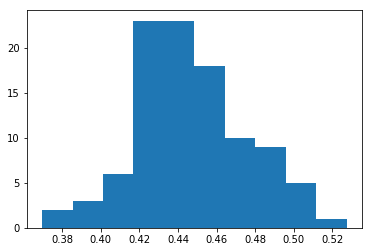

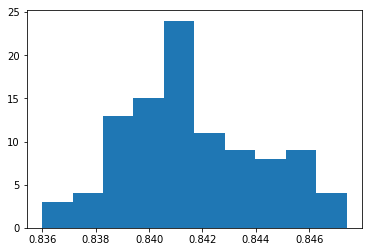

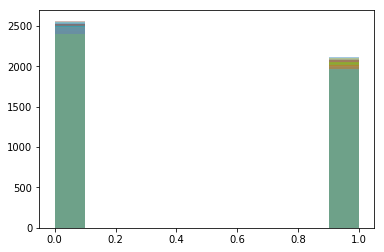

Mean of means: 0.44886868686868686
Std of means: 0.009644101578573996


In [65]:
mnz, agtz = zip(*distro_params)
plt.hist(mnz)
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [ ]:
data_cache = {}

In [ ]:
#tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [100]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["XENT"]
sq_nums = [(1000, 150)]
# sq_nums = [(3000, 450)]
# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1.0] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 1
bal = .5

for (n_students, n_questions) in sq_nums:
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:

                    model_list=[]
                    rasch=True

                    questions=None

                    tup = (n_factors, min_active, max_active) 
                    if tup in gen_m_cache:
                        gen_m = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)
                    
                    qws_list = []
                    sws_list = []
                    tr_list = []
                    params_list = []
                    # questions=None
                    real_stu_list=[]
                    real_que_list=[]
                    perseverance_list=[]
                    test_datasets=[]
                    sparss = []
    #                 qn_av = None
    #                 qn_std = None

                    pred_list = []

                    set_random_seed(666)
                    numpy.random.seed(666)
                    for a in range(n_runs):

                        found = False
                        while not found:
                            tw = random.uniform(0.5, 3.5)
    #                         a1 = random.uniform(1, 3.5)
                            a1 = random.uniform(1, 5)
                            a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

                            gen_new_data = False
                            if rasch:
                                if tup not in data_cache:
                                    print("Not data in cache for desired shape")
                                    gen_new_data = True
                                else:
                                    print("using datacache")
                                    (probs, students_temp, qz_temp) = data_cache[tup]
                                    if students_temp.shape != (n_students, n_factors) or qz_temp.shape!=(n_questions, n_factors):
                                        print("data shape has changed, need to make new data")
                                        gen_new_data = True
                                
                                if gen_new_data:
                                    print("gening data")
                                    _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
                                

                                
                            print("run created")
                            students2 = students_temp
                            questions = qz_temp

                            if explore_mode:
                                plot_items([], questions, None)

                                print("~ ~ ~ ~~ ATTEMPT",a, a0)
                                bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                                plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                                plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                                plt.show()

                        #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
                        #     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))


    #                         probs=numpy.zeros((len(students2), len(questions)))
                            obs=numpy.zeros((len(students2), len(questions)))

                            all_pairs = []
                            tr_pairs = []
                            v_pairs = []
                            tt_pairs = []
                            perseverance = []
                            slist = list(range(len(students2)))
                            random.seed(666)
                            shuffle(slist)
                            for vi in slist:
    #                             c=0
    #                             p_cont = (n_students * n_questions)//20
    #                             v_size = p_cont
                                qlist= list(range(len(questions)))
                                shuffle(qlist)
                                first = True
                                for mi in qlist:
                                    if first:
                                        tt_pairs.append((vi,mi))
                                        first = False
                                    else:
                                        tr_pairs.append((vi,mi))

                            print("splitting")
                            if spars < 1:
                                tr_pairs, _ = train_test_split(tr_pairs, train_size=spars)
                            tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1)
                            print("splut")

#                             print("scanning")
#                             for pa in tr_pairs:
#     #                             print(pa)
#                                 if pa in tt_pairs:
#                                     print("TR IN TT")
#                                     raise Exception
#                                 if pa in v_pairs:
#                                     print("TR IN V")
#                                     raise Exception
#                             print("scun")

    #                         print("tr_pairs", tr_pairs)
                            pfz, sz, qz = stitch_n_split(tr_pairs, probs)
                            vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)
#                             vpfz, vsz, vqz = [],[],[]

                            print("Sparsity",spars,"lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

                            print(probs)

                            hard =numpy.round(probs)
                            agt = 0 #numpy.zeros_like(probs)
                            n_agt_runs = 10
                            for _ in range(n_agt_runs):
                                this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                                this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                                agt += this_agt / n_agt_runs
                            print("*** AGT:", agt)                            

                            if explore_mode:
                                plt.hist(probs.flatten(), alpha=0.5)
                                plt.title("Histogram of $p_{pass}$")
                                plt.xlabel("$p_{pass}")
                                plt.ylabel("Frequency")
                                plt.legend()
                                plt.show()

                                plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                                plt.title("pfz")
                                plt.show()


                            print(tw, a1, a0)
                            mn = numpy.mean(pfz)
                            print(mn, numpy.mean(vpfz))
                            uppa = bal+0.05
                            lowa = bal-0.05
                            print("xhxwx ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                            if (mn >= lowa) and (mn <= uppa):
                                print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                                data_cache[tup] = (probs, students_temp, qz_temp)
                                found=True

                        hard=None
                        probs=None

                        print("mean pers is", numpy.mean(perseverance))
                        perseverance_list.append(perseverance)
                        real_stu_list.append(students2)
                        real_que_list.append(questions)
                        test_datasets.append(tt_pairs)
                        params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))
                    #     if numpy.mean(pfz) <0.4 or numpy.mean(pfz)>0.6:
                    #         continue

                    # for runix in range(n_runs):
                    #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
                        obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
                        print("binary obs?", obs_are_binary)

                        print("callio:")
                        print(len(qz),len(sz),len(pfz))
                        print(len(vqz),len(vsz),len(vpfz), emb_w)
    #                     nn_mode = "MLTM"
    #                     loss_mode = "XENT"
                        print("nn_mode", nn_mode)
                        s_table2, qn_table2, m2, h2 = generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, emb_w, n_factors, min_active, max_active, nn_mode=nn_mode, loss_mode=loss_mode)
    #                     qws2= copy.copy(qn_table2.get_weights()[0])
    #                     sws2= copy.copy(s_table2.get_weights()[0])
                        qws2= qn_table2.get_weights()[0]
                        sws2= s_table2.get_weights()[0]

                        pred_probs = m2.predict([qz, sz])
    #                     print(pred_probs)
                        pred_list.append(pred_probs)
                        model_list.append(m2)

                    #     qg = q_gates.get_weights()[0]
                    #     qg_list.append(qg)
                    #     if qn_av is None:
                    #         qn_av = numpy.mean(qws2)

                        sparss.append(spars)
                        sws_list.append(sws2)
                        qws_list.append(qws2)
                    tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
    #                 reportz.append(zlib.compress(pickle.dumps(tup)))
    #                 print(perseverance_list)

                    reportz.append(tup)
print("finished")

In [ ]:
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))
    report(*tup)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

# *****
# MLTM XENT
# 1 1 1 1 1 1 1
# params: 10 1 5 1 / 2.5806077740610034 2.347493116108512 [[ 0.821]] 0.459641891892 0.495
# R2 =  0.447788537896
# MAE =  0.204465762654
# 1000 x 150
# 0.749 0.0 / 0.204466 0.144075




In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]])
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1